In [2]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

In [3]:
### ETAPA 1: CRIAR FUNÇÃO DE PRÉ-PROCESSAMENTO PARA AS IMAGENS ###

# função pra redimensionar e normalizar a imagem:
def pre_process_images(image_path, target_size=(100,100)):

    image = cv2.imread(image_path)

    #redimensionamento:
    image = cv2.resize(image, target_size)

    #normalização dos valores dos pixels para o intervalo [0,1]:
    image = image.astype('float32') / 255.0

    return image

In [4]:
### ETAPA 2: LER OS ARQUIVOS DE IMAGENS 'live' DO DATASET ###

data_dir = 'C:/Users/biafe/OneDrive/Documentos/desafio most/MLChallenge_Dataset/Data'

# lista que irá armazenar as imagens live:
live_images = []

# lista com todas as pastas IDs:
id_folders = os.listdir(data_dir)

# Passar por cada pasta ID:
for id_folder in id_folders:
    id_path = os.path.join(data_dir, id_folder)

    # checar se existe uma pasta 'live' dentro da pasta ID:
    live_folder_path = os.path.join(id_path, 'live')
    if not os.path.exists(live_folder_path):
        continue

    # lista das imagens dentro da pasta live:
    live_image_files = os.listdir(live_folder_path)

    # passar por cada imagem:
    for live_img_file in live_image_files:
        live_img_path = os.path.join(live_folder_path, live_img_file)

        #função de pré-processamento das imagens:
        live_image_processed = pre_process_images(live_img_path)

        # imagem live armazenada na lista
        live_images.append(live_image_processed)

In [5]:
### ETAPA 3: CONSTRUÇÃO DO AUTOENCODER ###

# com o autoencoder, podemos treiná-lo para reconstruir somente as imagens live.
# assim, quando o modelo receber uma imagem spoof, ele não saberá reconstruí-la. Portanto, a distância entre o input e o output será maior do que em situações live.
# vale ressaltar que essa lógica é aplicável, já que estamos lidando com classificação binária.

# Dividindo em treino (60%), teste (20%) e validação (20%)
x_train, x_temp = train_test_split(live_images, test_size=0.4, random_state=42)
x_test, x_val = train_test_split(x_temp, test_size=0.5, random_state=42)

# converter as listas em arrays:
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("x_val shape:", x_val.shape)


x_train shape: (5732, 100, 100, 3)
x_test shape: (1911, 100, 100, 3)
x_val shape: (1911, 100, 100, 3)


In [7]:
# AUTOENCODER:


input_shape = (100, 100, 3)

# Arquitetura do encoder:
input_img = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Arquitetura do decoder:
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# modelo:
autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.summary()

# Treino:
autoencoder.fit(x_train, x_train, epochs=10, batch_size=32, shuffle=True)

# salvar o modelo treinado:
save_path = 'C:/Users/biafe/OneDrive/Documentos/desafio most'

autoencoder.save(save_path)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 25, 25, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 25, 25, 64)        3692

INFO:tensorflow:Assets written to: C:/Users/biafe/OneDrive/Documentos/desafio most\assets


In [6]:
### ETAPA 4: LER OS ARQUIVOS DE IMAGENS 'spoof' DO DATASET ###

# lista que irá armazenar as imagens spoof:
spoof_images = []

# lista com todas as pastas IDs:
id_folders = os.listdir(data_dir)

# Passar por cada pasta ID:
for id_folder in id_folders:
    id_path = os.path.join(data_dir, id_folder)

    # checar se existe uma pasta 'spoof' dentro da pasta ID:
    spoof_folder_path = os.path.join(id_path, 'spoof')
    if not os.path.exists(spoof_folder_path):
        continue

    # lista das imagens dentro da pasta spoof:
    spoof_image_files = os.listdir(spoof_folder_path)

    # passar por cada imagem:
    for spoof_img_file in spoof_image_files:
        spoof_img_path = os.path.join(spoof_folder_path, spoof_img_file)

        #função de pré-processamento das imagens:
        spoof_image_processed = pre_process_images(spoof_img_path)

        # imagem live armazenada na lista
        spoof_images.append(spoof_image_processed)

In [7]:
spoof_images = np.array(spoof_images)
print(spoof_images.shape)
np.random.shuffle(spoof_images)

spoof_images = spoof_images[:1911]
print(spoof_images.shape)

(19531, 100, 100, 3)
(1911, 100, 100, 3)


In [8]:
### ETAPA 5: CÁLCULO DO CUSTO DE RECONSTRUÇÃO MÉDIO DO AUTOENCODER ###

save_path = 'C:/Users/biafe/OneDrive/Documentos/desafio most'

# carregando o modelo salvo:
loaded_autoencoder = load_model(save_path)

# testando com os dados de teste:
reconstructions = loaded_autoencoder.predict(x_val)

# cálculo do custo de reconstrução dos dados de teste, isto é, quão próxima a imagem reconstruída está da entrada:
sz = x_val.shape[0]    #sz = tamanho do vetor 
live_reconstruction_cost = np.array([np.linalg.norm(np.subtract(x_val[i],reconstructions[i])) for i in range(0,sz)])

# cálculo da média destes custos:
live_mean_cost = np.mean(live_reconstruction_cost)

print(live_reconstruction_cost)
print(live_mean_cost)

60/60 [==============================] - 17s 247ms/step
[11.086519 10.324044 11.420893 ... 11.758522 10.925189 10.838074]
11.349098


In [9]:
### ETAPA 6: TESTE GERAL ###

test = np.concatenate((x_test, spoof_images), axis=0)

print(test.shape)

reconstructed_image = loaded_autoencoder.predict(test)

sz = test.shape[0]
reconstruction_cost = np.array([np.linalg.norm(np.subtract(test[i],reconstructed_image[i])) for i in range(0,sz)])


(3822, 100, 100, 3)
120/120 [==============================] - 33s 254ms/step


In [10]:
# função para checar a label da imagem
# se o custo de reconstrução for maior que o limite estipulado, a imagem será considerada spoof
def check_label(limit, reconstruction_cost):
    if reconstruction_cost > limit:
        label = 1 # spoof
    else:
        label = 0 # live
    
    return label

In [25]:
### ETAPA 7: MÉTRICAS ###

# cálculo da efetividade do modelo:

threshold = 11.34
labels_predicted = []

for index, cost in enumerate(reconstruction_cost):
    label = check_label(threshold, cost)
    labels_predicted.append(label)


print(labels_predicted)

[1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 

In [26]:
live_labels = np.zeros(1911)
spoof_labels = np.ones(1911)
labels_correct = np.concatenate((live_labels, spoof_labels), axis=0)
print(len(labels_correct))

3822


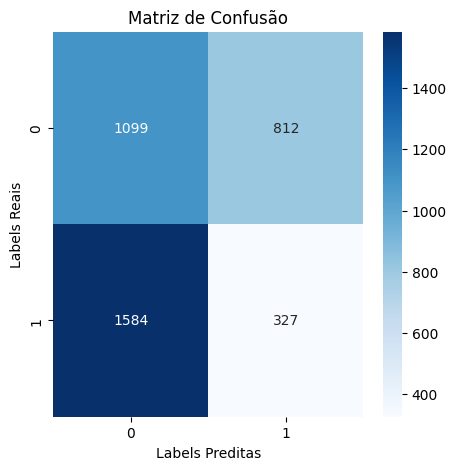

In [27]:
# construção da matriz de confusão:
matriz_confusao = confusion_matrix(labels_correct, labels_predicted)

plt.figure(figsize=(5, 5))
sns.heatmap(matriz_confusao, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Labels Preditas")
plt.ylabel("Labels Reais")
plt.title("Matriz de Confusão")
plt.show()

In [28]:
# outras métricas:

TP = matriz_confusao[0][0]  # verdadeiros positivos
FP = matriz_confusao[0][1]  # falsos positivos
FN = matriz_confusao[1][0]  # falsos negativos
TN = matriz_confusao[1][1]  # verdadeiros negativos

acuracia = (TP + TN) / (TP + FP + FN + TN)
precisao = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precisao * recall) / (precisao + recall)

print(f"Acurácia: {acuracia:.2f}")
print(f"Precisão: {precisao:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")


Acurácia: 0.37
Precisão: 0.58
Recall: 0.41
F1 Score: 0.48
